## 鐵達尼號生存預測（分類）
### 共通事前處理,導入資料,確認資料大小

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dtrain = pd.read_csv(r'C:\Users\空白\Desktop\Titanic\train.csv')
dtest = pd.read_csv(r'C:\Users\空白\Desktop\Titanic\test.csv')

In [26]:
dtrain.shape, dtest.shape

((891, 12), (418, 11))

#### 特徵項目  
  
PassengerId  乘客編號  
Survived     存活  
Pclass       艙等  
Name         姓名  
Sex          性別  
Age          年齡  
SibSp        手足/配偶
Parch        家庭/父母子女
Ticket       船票
Fare         票價
Cabin        艙房號碼
Embarked     登船口


### 創造新欄位['Title']  
步驟:  
* 從姓名中取出稱謂
* 以長條圖查看跟生存率的關聯
* 透過圖示可以知道只有4個稱謂的值較為明顯
* 合併值相對低的稱謂


In [27]:
import re 
regex = re.compile('([A-Za-z]+)\.')
dtrain['Title']= dtrain.Name.map(lambda x : regex.search(x)[0])
dtrain['Title']= dtrain.Title.map(lambda x : x[0:][:-1] )
dtrain['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

<Axes: xlabel='Title', ylabel='count'>

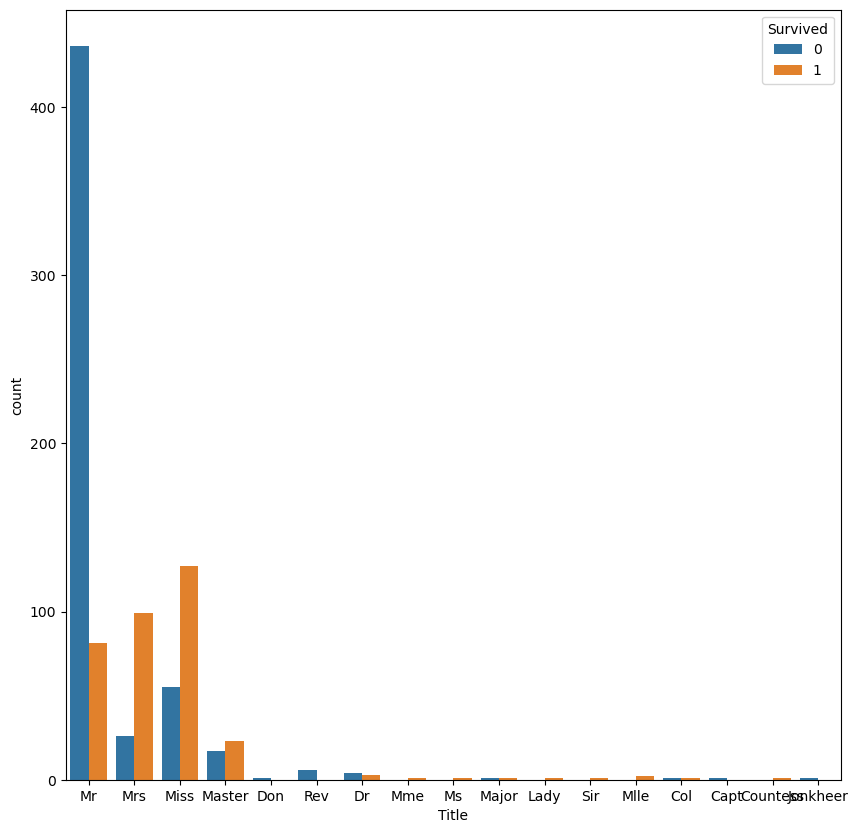

In [28]:
df1 = dtrain.copy()
df1['Survived']= df1.Survived.astype('str')
plt.figure(figsize=(10,10))
sns.countplot(x=df1['Title'],hue=df1['Survived'])

In [29]:
dtrain['Title']=dtrain.Title.replace(['Don','Rev','Dr','Major','Col','Capt','Lady','Sir','Countess','Jonkheer','Dona'],'Rare')
dtrain['Title']=dtrain.Title.replace(['Ms','Mlle'],'Miss')
dtrain['Title']=dtrain.Title.replace([ 'Mme'],'Mrs')
dtrain['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [30]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


### 創建新欄位['Age_Mean'], 填補年齡遺失值  
流程:    
* 以稱謂創分組算出各組平均年齡
* 找出有遺失值的年齡欄位，以對應的稱謂平均年齡賦值

In [31]:
Age_Mean= dtrain.pivot_table('Age',index='Title',aggfunc='mean')
Age_Mean.columns= ['Age_Mean']
Age_Mean.reset_index(inplace=True)
Age_Mean

,Title,Age_Mean
0,Master,4.574167
1,Miss,21.845638
2,Mr,32.368090
3,Mrs,35.788991
4,Rare,45.545455


In [32]:
dtrain.loc[(dtrain['Age'].isnull())&(dtrain['Title']=='Master'),'Age']=Age_Mean.loc[Age_Mean['Title']=='Master','Age_Mean'][0]
dtrain.loc[(dtrain['Age'].isnull())&(dtrain['Title']=='Miss'),'Age']=Age_Mean.loc[Age_Mean['Title']=='Miss','Age_Mean'][1]
dtrain.loc[(dtrain['Age'].isnull())&(dtrain['Title']=='Mr'),'Age']=Age_Mean.loc[Age_Mean['Title']=='Mr','Age_Mean'][2]
dtrain.loc[(dtrain['Age'].isnull())&(dtrain['Title']=='Mrs'),'Age']=Age_Mean.loc[Age_Mean['Title']=='Mrs','Age_Mean'][3]
dtrain.loc[(dtrain['Age'].isnull())&(dtrain['Title']=='Rare'),'Age']=Age_Mean.loc[Age_Mean['Title']=='Rare','Age_Mean'][4]

### 以散布圖觀察票價跟艙等的關係  
* 每個艙等都有0$的情況
* 進一步觀察票價為0的生存率普遍統一，先不處理

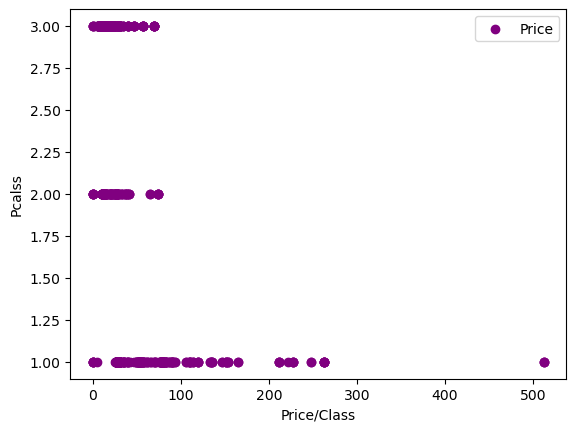

In [33]:
plt.scatter(dtrain['Fare'],dtrain['Pclass'],color='purple',label='Price')
plt.xlabel('Price/Class')
plt.ylabel('Pcalss')
plt.legend()
plt.show()

In [34]:
dtrain.loc[dtrain['Fare']==0,'Survived']

179    0
263    0
271    1
277    0
302    0
413    0
466    0
481    0
597    0
633    0
674    0
732    0
806    0
815    0
822    0
Name: Survived, dtype: int64

### 以性別, 艙等跟存活率的關聯創造新欄位['Sex_Class']  
觀察性別, 艙等跟存活率可以得出幾個結論:  
* 女性平均存活率在50%以上  
* 頭等艙跟2等艙的女性有平均90%的機率會存活  
* 即使是頭等艙的男性有只有平均不到40%的存活率  
* 2等跟3等艙的男性生存率只有15%$左右  

處理方式: 照性別/艙等的平均存活率由大到小, 以6到1填入新欄位['Sex_Class']

In [35]:
Sex_Class=dtrain.pivot_table('Survived',index=['Sex','Pclass'],aggfunc= lambda x: np.mean(x)*100)
Sex_Class.colums=['Survived(%)']
Sex_Class.reset_index(inplace=True)
Sex_Class

C:\Users\空白\AppData\Local\Temp\ipykernel_13872\3543094066.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Sex_Class.colums=['Survived(%)']


,Sex,Pclass,Survived
0,female,1,96.808511
1,female,2,92.105263
2,female,3,50.000000
3,male,1,36.885246
4,male,2,15.740741
5,male,3,13.544669


In [36]:
dtrain.loc[(dtrain['Sex']=='female')&(dtrain['Pclass']==1),'Sex_Class']=6
dtrain.loc[(dtrain['Sex']=='female')&(dtrain['Pclass']==2),'Sex_Class']=5
dtrain.loc[(dtrain['Sex']=='female')&(dtrain['Pclass']==3),'Sex_Class']=4
dtrain.loc[(dtrain['Sex']=='male')&(dtrain['Pclass']==1),'Sex_Class']=3
dtrain.loc[(dtrain['Sex']=='male')&(dtrain['Pclass']==2),'Sex_Class']=2
dtrain.loc[(dtrain['Sex']=='male')&(dtrain['Pclass']==3),'Sex_Class']=1

### 確認各欄位資料型態，Label Encoding

In [37]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Title        891 non-null    object 
 13  Sex_Class    891 non-null    float64
dtypes: float64(3), int64(5), object(6)
memory usage: 97.6+ KB


In [38]:
sex_mapping={'male':0,'female':1}
dtrain['Sex']=dtrain['Sex'].map(sex_mapping)

<Axes: xlabel='Embarked', ylabel='count'>

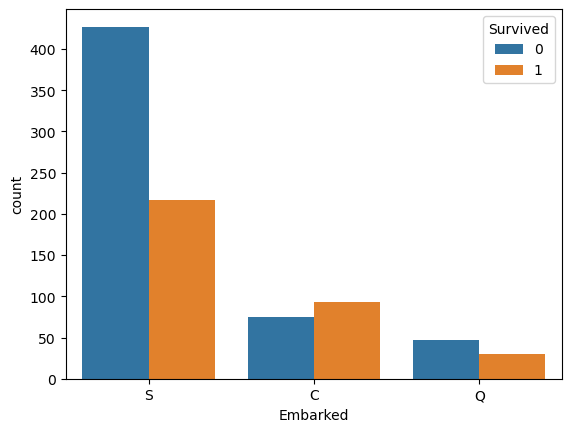

In [39]:
sns.countplot(x=df1['Embarked'],hue=df1['Survived'])

In [40]:
dtrain['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [41]:
dtrain=dtrain.dropna(subset='Embarked')

In [42]:
dtrain['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [43]:
em_mapping={'S':3,'C':2,'Q':1}
dtrain['Embarked']=dtrain['Embarked'].map(em_mapping)
dtrain['Embarked'].head()

0    3
1    2
2    3
3    3
4    3
Name: Embarked, dtype: int64

<Axes: xlabel='Title', ylabel='count'>

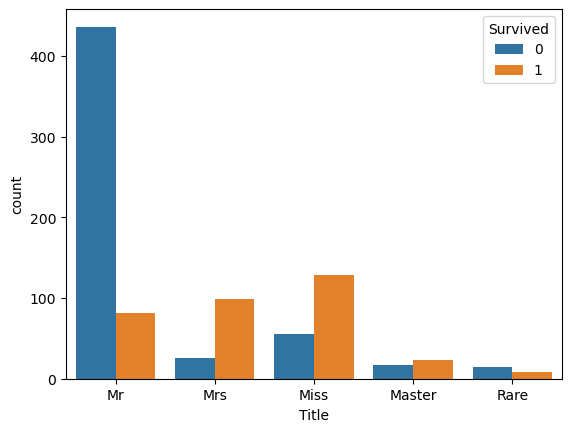

In [44]:
df1=dtrain.copy()
df1['Survived']=df1['Survived'].astype('str')
sns.countplot(x=df1['Title'],hue=df1['Survived'])

In [45]:
ti_mapping={'Miss':5,'Mrs':4,'Mr':3,'Master':2,'Rare':1}
dtrain['Title']=dtrain['Title'].map(ti_mapping)
dtrain['Title'].head()

0    3
1    4
2    5
3    4
4    3
Name: Title, dtype: int64

### 丟掉非必要欄位, 確認資料型態, 缺失值

In [46]:
dtrain.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

In [47]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   889 non-null    int64  
 1   Pclass     889 non-null    int64  
 2   Sex        889 non-null    int64  
 3   Age        889 non-null    float64
 4   SibSp      889 non-null    int64  
 5   Parch      889 non-null    int64  
 6   Fare       889 non-null    float64
 7   Embarked   889 non-null    int64  
 8   Title      889 non-null    int64  
 9   Sex_Class  889 non-null    float64
dtypes: float64(3), int64(7)
memory usage: 76.4 KB


In [48]:
dtrain

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Sex_Class
0,0,3,0,22.000000,1,0,7.2500,3,3,1.0
1,1,1,1,38.000000,1,0,71.2833,2,4,6.0
2,1,3,1,26.000000,0,0,7.9250,3,5,4.0
3,1,1,1,35.000000,1,0,53.1000,3,4,6.0
4,0,3,0,35.000000,0,0,8.0500,3,3,1.0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000,3,1,2.0
887,1,1,1,19.000000,0,0,30.0000,3,5,6.0
888,0,3,1,21.845638,1,2,23.4500,3,5,4.0
889,1,1,0,26.000000,0,0,30.0000,2,3,3.0


### 設定樣本資料大小, 導入模型,標準化及分割訓練集測試集

In [49]:
x= dtrain.iloc[:,1:10].values
y= dtrain.iloc[:,0].values

In [50]:
x.shape,y.shape

((889, 9), (889,))

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
sc =StandardScaler()
x_std=sc.fit_transform(x)
x_train, x_test, y_train, y_test =train_test_split(x_std,y,test_size=0.2,random_state=0)


### 模型初始化, 訓練

In [53]:

def models(x_train, y_train):
    log = LogisticRegression(random_state=0)
    log_cv=cross_val_score(log,x_train, y_train, cv=5).mean()
    log.fit(x_train,y_train)
    
    knn =KNeighborsClassifier(n_neighbors=5)
    knn_cv=cross_val_score(knn,x_train, y_train, cv=5).mean()
    knn.fit(x_train,y_train)

    svc = SVC(random_state=0)
    svc_cv=cross_val_score(svc,x_train, y_train, cv=5).mean()
    svc.fit(x_train, y_train)

    forest = RandomForestClassifier(random_state=0)
    forest_cv=cross_val_score(forest,x_train, y_train, cv=5).mean()
    forest.fit(x_train,y_train)

    tree = DecisionTreeClassifier(random_state=0)
    tree_cv=cross_val_score(tree,x_train, y_train, cv=5).mean()
    tree.fit(x_train, y_train)

    XGBC = XGBClassifier(random_state=0)
    XGBC_cv=cross_val_score(XGBC,x_train, y_train, cv=5).mean()
    XGBC.fit(x_train, y_train)

    model_names =['log','knn','svc','forest','tree','XGBC']

    for index, name in enumerate(model_names):
        cv_score = eval(f'{name}_cv')
        train_score = eval(f'{name}.score(x_train, y_train)')
        test_score= eval(f'{name}.score(x_test, y_test)')
        print(f'[{index}] {name} Accuracy (CV): {cv_score:.2f}, Training Accuracy: {train_score:.2f}, Test Accuract:{test_score:.2f}')
    


    return log,knn,svc,forest,tree,XGBC






### 模型評估及超參數調整  
評估:  
* 模型的交叉驗證跟訓練及分數普遍高於訓練集分數  
* 隨機森林, 決策樹跟XGboost的交叉驗證分數低於訓練集分數，可能有Overfitting的情況  
  
調整:  
* 透過for 迴圈搭配超參數範圍分別檢驗KNN, 隨機森林, 決策樹  
* 隨機森林的樹大概在200棵比較合適  
* 決策數可能在最大深度可能在3或4  
* knn的k值以圖來說在10最合適, 實際上以網格搜尋最佳k值也是10


In [54]:
model= models(x_train,y_train)

[0] log Accuracy (CV): 0.83, Training Accuracy: 0.83, Test Accuract:0.72
[1] knn Accuracy (CV): 0.83, Training Accuracy: 0.88, Test Accuract:0.71
[2] svc Accuracy (CV): 0.85, Training Accuracy: 0.87, Test Accuract:0.75
[3] forest Accuracy (CV): 0.82, Training Accuracy: 0.99, Test Accuract:0.76
[4] tree Accuracy (CV): 0.80, Training Accuracy: 0.99, Test Accuract:0.72
[5] XGBC Accuracy (CV): 0.84, Training Accuracy: 0.98, Test Accuract:0.75


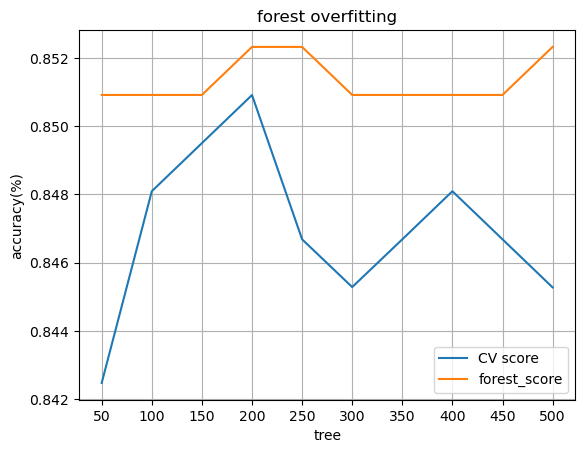

In [55]:
f_cv_score=[]
f_score=[]
x=(np.arange(10)+1) *50
x_str=[str(n) for n in x]

for t in x:
    trees =RandomForestClassifier(n_estimators=t, max_depth=3, random_state=0)
    trees.fit(x_train, y_train)
    f_cv_score.append(cross_val_score(trees, x_train, y_train ,cv=5).mean())
    f_score.append(trees.score(x_train,y_train))

plt.title('forest overfitting')
plt.plot(x_str, f_cv_score, label='CV score')
plt.plot(x_str, f_score, label='forest_score')
plt.xlabel('tree')
plt.ylabel('accuracy(%)')
plt.legend()
plt.grid(True)
plt.show()

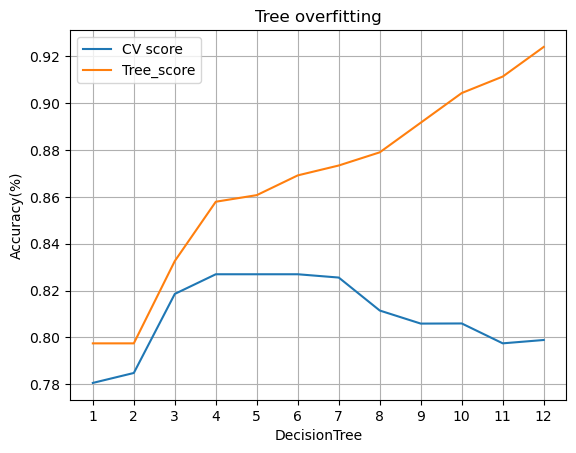

In [56]:
tcv_score=[]
t_score=[]

x = np.arange(12)+1
x_str=[str(n) for n in x]

for d in x:
    dtree = DecisionTreeClassifier(max_depth=d)
    dtree.fit(x_train,y_train)
    tcv_score.append(cross_val_score(dtree, x_train, y_train, cv=10).mean())
    t_score.append(dtree.score(x_train,y_train))

plt.title('Tree overfitting')
plt.plot(x_str,tcv_score, label='CV score')
plt.plot(x_str,t_score, label='Tree_score')
plt.xlabel('DecisionTree')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.grid(True)
plt.show()

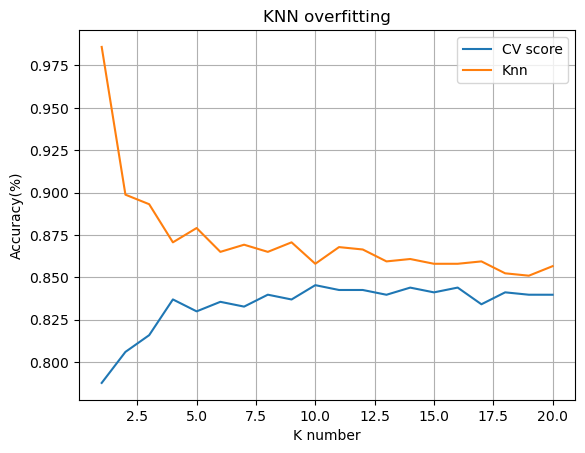

In [57]:
kcv_score=[]
k_score=[]
x= np.arange(20)+1

for k in x:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    kcv_score.append(cross_val_score(knn,x_train,y_train).mean())
    k_score.append(knn.score(x_train,y_train))

plt.title('KNN overfitting')
plt.plot(x,kcv_score, label='CV score')
plt.plot(x,k_score,label='Knn')
plt.xlabel('K number')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
from sklearn.model_selection import GridSearchCV
param_grid={'n_neighbors':np.arange(20)+1}
kmodel=GridSearchCV(KNeighborsClassifier(),param_grid)
kmodel.fit(x_train,y_train)

print('Best param', kmodel.best_params_)
print('CV score:',kmodel.best_score_.round(3) )
print('Test score:',kmodel.score(x_test,y_test).round(3))

Best param {'n_neighbors': 10}
CV score: 0.845
Test score: 0.753


### 重要性分析  
對樹型模型進行重要性分析:  
* 隨機森林的前四項重要性佔筆算蠻平穩的下降  
* 決策樹開前兩名差了20%
* XGboost幾乎是一枝獨秀的Sex欄位佔比63%, 接下來除17%的艙等其餘不到10%

,RandomForestClassifier
features,
Age,0.231
Fare,0.207
Sex_Class,0.160
Sex,0.149
Title,0.093
SibSp,0.049
Pclass,0.045
Embarked,0.038
Parch,0.028


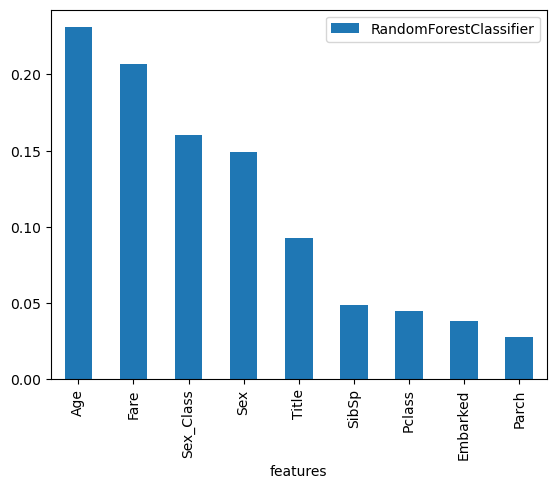

,DecisionTreeClassifier
features,
Sex_Class,0.436
Age,0.235
Fare,0.188
SibSp,0.049
Embarked,0.046
Title,0.022
Parch,0.021
Pclass,0.003
Sex,0.000


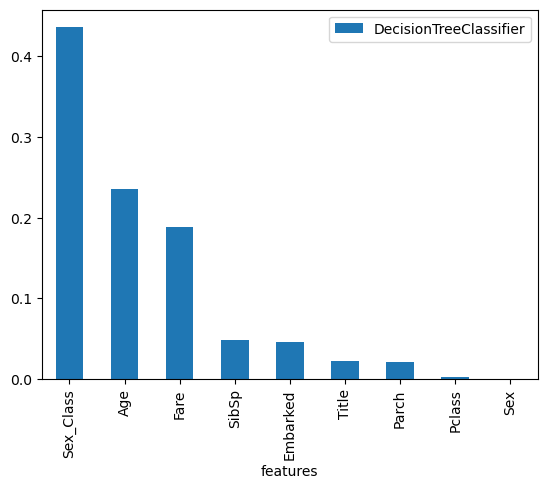

,XGBClassifier
features,
Sex,0.639
Pclass,0.170
Sex_Class,0.058
SibSp,0.045
Embarked,0.023
Age,0.020
Fare,0.019
Parch,0.016
Title,0.010


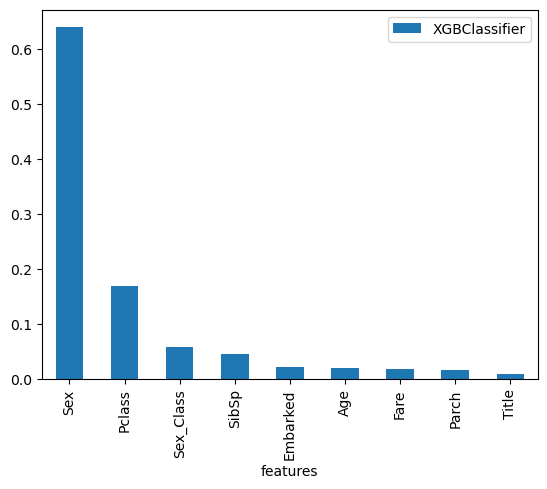

In [59]:
mods= model[3:6]
for i in mods:
    i_str=str(i)
    # print(i_str)
    reg = re.compile('([A-Za-z]+)\(')
    name = reg.search(i_str)[0]
    name = name[0:][:-1]
    importances = pd.DataFrame({'features':dtrain.iloc[:,1:10].columns,f'{name}':np.round(i.feature_importances_,3)})
    importances = importances.sort_values(f'{name}',ascending=False).set_index('features')
    display(importances)

    importances.plot.bar()
    plt.show()

### 調整超參數後再初始化, 訓練模型  
   
取得合適的超參數之後再對隨機森林、決策樹、KNN進行調整  
隨機森林n_estimators=200  
決策樹max_depth=3  
Knnn_neighbors=10  

In [63]:
def models2(x_train, y_train):
    log2 = LogisticRegression(random_state=0)
    log2_cv=cross_val_score(log2,x_train, y_train, cv=5).mean()
    log2.fit(x_train,y_train)
    
    knn2 =KNeighborsClassifier(n_neighbors=10)
    knn2_cv=cross_val_score(knn2,x_train, y_train, cv=5).mean()
    knn2.fit(x_train,y_train)

    svc2 = SVC(random_state=0)
    svc2_cv=cross_val_score(svc2,x_train, y_train, cv=5).mean()
    svc2.fit(x_train, y_train)

    forest2 = RandomForestClassifier(n_estimators=200, max_depth=3,random_state=0)
    forest2_cv=cross_val_score(forest2,x_train, y_train, cv=5).mean()
    forest2.fit(x_train,y_train)

    tree2 = DecisionTreeClassifier(max_depth=3,random_state=0)
    tree2_cv=cross_val_score(tree2,x_train, y_train, cv=5).mean()
    tree2.fit(x_train, y_train)

    XGBC2 = XGBClassifier(random_state=0)
    XGBC2_cv=cross_val_score(XGBC2,x_train, y_train, cv=5).mean()
    XGBC2.fit(x_train, y_train)

    model_names2 =['log2','knn2','svc2','forest2','tree2','XGBC2']

    for index, name in enumerate(model_names2):
        cv_score = eval(f'{name}_cv')
        train_score = eval(f'{name}.score(x_train, y_train)')
        test_score= eval(f'{name}.score(x_test, y_test)')
        print(f'[{index}] {name} Accuracy (CV): {cv_score:.2f}, Training Accuracy: {train_score:.2f}, Test Accuract:{test_score:.2f}')

    return log2,knn2,svc2,forest2,tree2,XGBC2

### 超參數調整後分數差異  
Knn從CV:0.83→0.85, Train:0.88→0.86  
隨機森林從CV:0.82→0.85, Train:0.99→0.85  
決策樹從CV:0.80→0.82, Train:0.99→0.83  
雖然跟測試集的分數還是有落差，以交叉驗證跟訓練集分數來說調整超參數還是有效的

In [64]:
model2= models2(x_train,y_train)

[0] log2 Accuracy (CV): 0.83, Training Accuracy: 0.83, Test Accuract:0.72
[1] knn2 Accuracy (CV): 0.85, Training Accuracy: 0.86, Test Accuract:0.75
[2] svc2 Accuracy (CV): 0.85, Training Accuracy: 0.87, Test Accuract:0.75
[3] forest2 Accuracy (CV): 0.85, Training Accuracy: 0.85, Test Accuract:0.76
[4] tree2 Accuracy (CV): 0.82, Training Accuracy: 0.83, Test Accuract:0.72
[5] XGBC2 Accuracy (CV): 0.84, Training Accuracy: 0.98, Test Accuract:0.75


### 超參數調整後重要性分析  
* 隨機森林- 調整前佔比最高為Age, 調整後為Sex_Class佔30%左右,性別跟稱謂則來到第2.3名  
* 決策樹- 雖然調整前後佔比最重皆為Sex_Class，但調整前只有43%調整後幾乎是一個獨大的來到84$  
  
### 總結:  
雖然調整超參數之後CV驗證跟訓練集的驗證分數差距有下降  
但是透過重要性分析能得知指標對於模型的重要性有明顯變動, 有可能限縮了調整指標的彈性  
也能看出樹型模型對於這個主題表現可能有待探討  
反而是KNN在調整超參數之後不論是交叉驗證或驗證集跟測試集都有提升  
SVC支援向量機跟邏輯斯回歸即使沒有調整C值也有不錯的表現。

,RandomForestClassifier
features,
Sex_Class,0.326
Sex,0.227
Title,0.191
Pclass,0.074
Age,0.067
Fare,0.065
SibSp,0.023
Embarked,0.019
Parch,0.009


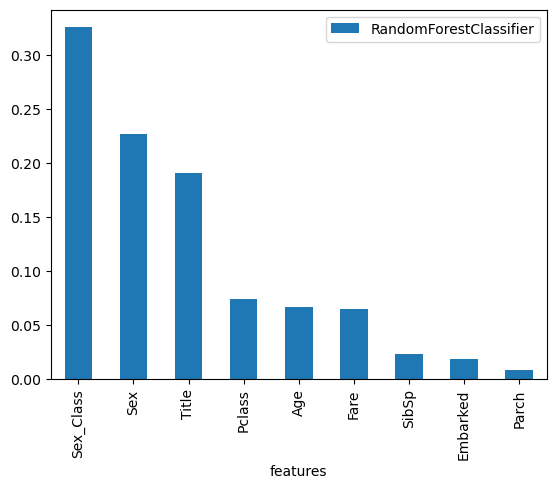

,DecisionTreeClassifier
features,
Sex_Class,0.847
Age,0.085
Embarked,0.057
Parch,0.006
Fare,0.004
Pclass,0.000
Sex,0.000
SibSp,0.000
Title,0.000


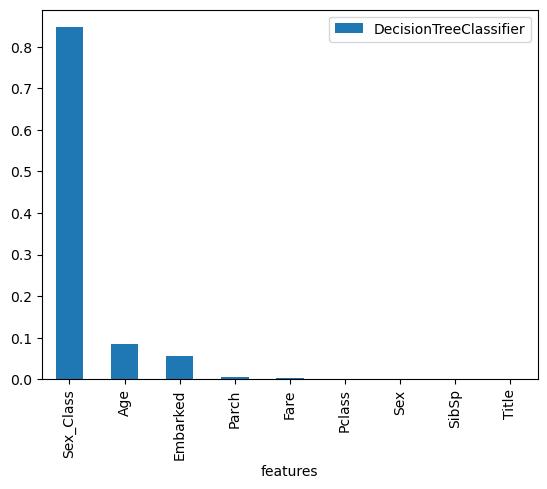

,XGBClassifier
features,
Sex,0.639
Pclass,0.170
Sex_Class,0.058
SibSp,0.045
Embarked,0.023
Age,0.020
Fare,0.019
Parch,0.016
Title,0.010


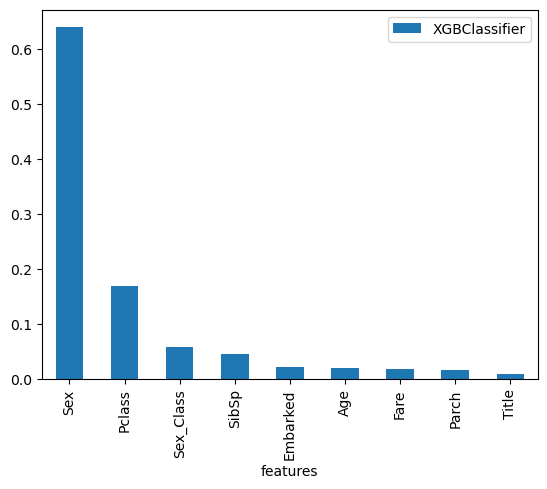

In [66]:
mods2= model2[3:6]
for i in mods2:
    i_str=str(i)
    # print(i_str)
    reg = re.compile('([A-Za-z]+)\(')
    name = reg.search(i_str)[0]
    name = name[0:][:-1]
    importances = pd.DataFrame({'features':dtrain.iloc[:,1:10].columns,f'{name}':np.round(i.feature_importances_,3)})
    importances = importances.sort_values(f'{name}',ascending=False).set_index('features')
    display(importances)

    importances.plot.bar()
    plt.show()